## Table of contents

* [1. Background](#Background)
* [2. Imports](#import)
* [3. Load the data](#Load_Data)
* [4. Is the data imbalanced?](#imblnc)
* [5. Data preparation prior to model training](#pre)
* [6. Choose the right metrics for model evaluation](#metrics)
* [7. Train models](#model)
    * [7.1. Logistic regression](#lr)
        * [7.1.1.  Make a pipeline for logistic regression model training](#pllr)
        * [7.1.2. Hyperparameter search using GridSearchCV for logistic regression](#gdlr)
        * [7.1.3. Best Logistic Regression model](#bestlr)
    * [7.2. Decision tree classifier](#dt)
        * [7.2.1. Make a pipeline for decision tree](#pldt)
        * [7.2.2. Hyperparameter search for decision tree classifier](#gddt)
        * [7.2.3. Decision tree classifier with best parameters](#bestdt)
        * [7.2.4. Feature importance assessment in the decision tree classifier](#fidt)
    * [7.3. Random forest classifier](#rf)
        * [7.3.1. Make a pipeline for random forest classifier](#plrf)
        * [7.3.2. Hyperparameter search for random forest classifier](#gdrf)
        * [7.3.3. Rondom forest classifier feature importance assessment](#firf)
    * [7.4. Gradient boosting classifier](#GB)
        * [7.4.1. Make a pipeline for gradient boosting classifier](#plgb)
        * [7.4.2. Hyperparameter tuning for gradient boosting classifier](#gdgb)
        * [7.4.3. Gradient boosting feature importance assessment](#figb)
* [8. Final model selection](#select)
    * [8.1. Logistic regressio](#lr_test)
    * [8.2. Decision tree](#dt_test)
    * [8.3 Random forest](#rf_test)
    * [8.4. XGBoost](#XG_test)
    * [8.5. Discussion](#disc)
* [9. Save the best model](#save_model)
* [10. Summary](#discussion)    

# 1. Background  <a class='anchor' id='Background'></a>

In this notebook we will apply several calssification models to our cleaned data frame of accepted loans from Lending Club. Briefly, Lending Club used to be the biggest peer to peer lending platform. To decide about a loan application, Lending Club relies on applicants' information provided during application. Such information includes income, length employment and credit history. In previous notebooks, we addressed missing data and explore the data to get a better understanding of the data 

In this notebook we will apply several classification models to predict if a loan will default. The models are:

1. Logistic regression

2. Decision tree

3. Random Forest



# 2. Imports <a class='anchor' id='import'></a>

We start by importing required packages.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import NearMiss, RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle


# 3. Load the data<a class='anchor' id='Load_Data'></a>

Using the pd.read_csv, we load the data

In [40]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")
df = df.drop(columns=['id', 'Unnamed: 0'])

# 4. Is the data imbalanced? <a class='anchor' id='imblnc'><a/>

A data set is called [imbalanced](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), if the minority class makes a small percentage of the data set. 

If the minority class (in our case the defaulted loans) makes 20 to 40% of a data set, then it is mildly imbalance.
if the minority class is 1 to 20%, then the dataset is moderately imbalanced and if minority class is < 1% of data set, the data is extremely imbalanced.

To find out if our data set is imbalanced or not, we will look at waht percentages of loan applications in the data frame is defaulted

In [41]:
df.Status.value_counts()/len(df)

Fully Paid    0.784132
Default       0.215868
Name: Status, dtype: float64

Default loans count for 22% of our data set. Therefore, our data is mildly imbalance, which may or may not be a problem. It is suggested to model with the true distribution and if it was not fine, apply techncis such as undersampling to deal with the imbalance.

# 5. Data preparation prior to model training <a class='anchor' id='pre'><a/>

Due to complexity of our data frame, we definde two functions to handle all the prerocessing steps we need to do prior to training. These steps are:

1. Defining X and y
2. Applying One Hot Encoder to change categorical data
3. Under sampling the data by using RandomUnderSampler
4. spliting the data into training and testing sets.


In [42]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

Xcol_names = X.columns
ycol_name =['Status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

# Change back to panads dataframe
X_train = pd.DataFrame(X_train, columns=Xcol_names)
X_test = pd.DataFrame(X_test, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)
y_test = pd.DataFrame(y_test, columns=ycol_name)



The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74


# 6. Choose the right metrics for model evaluation <a class='anchor' id='metrics'></a>

Given that the data is mildly imbalanced, accuracy score is not a good metrics to evaluate performance of a model. It is [recommended](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html#:~:text=1%20Use%20the%20right%20evaluation%20metrics.%20Applying%20inappropriate,keep%20the%20models%20as%20a%20fixed%20component.%20) to use evaluation metrics such as precision, recal, f1 score or balanced accuracy. We use "balanced accuracy" as our evaluation metrics to compare model performance. 


# 7. Model training <a class='anchor' id='model'></a>

Following classifiers will be trained on the test data:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost

Steps that we follow for each model include:

1. Make a pipeline, that includes the model and scaling steps and then use cross valiadtion to train a general model. 

2. Grid search to find the hyperparameters.

3. Train the model with the tuned hyperparameters and study feature importance

After training all 4 models, I will use them on the test data and will compare the results to choose the model with the most predictive power.

## 7.1. Logistic regression <a class='anchor' id='lr'></a>

### 7.1.1.  Make a pipeline for logistic regression classifier <a class='anchor' id='pllr'></a>

Using make_pipeline, a pipeline is created to train logistic regression classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

To avoid overfitting, we use cross validation with 5 folds.

In [93]:
# General lr
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)

lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
lr_cv_scores = lr_cv_results['test_score']

print('Balanced accuaracy scores of 5 fold logistic regression are: ', lr_cv_scores)
print('Mean and standard deviation of balanced accuaracy scores of 5 fold logistic regression is: ', lr_cv_scores.mean(),  ' ,' , lr_cv_scores.std())

Balanced accuaracy scores of 5 fold logistic regression are:  [0.65394849 0.65172379 0.6554796  0.65475217 0.65394346]
Mean and standard deviation of balanced accuaracy scores of 5 fold logistic regression is:  0.6539695020989218  , 0.0012599475627318266


### 7.1.2. Hyperparameter search using GridSearchCV for logistic regression <a class='anchor' id='gdlr'></a>

Logistic regression has several parameters to tune. These parameters are shown by using get_params().keys(). Given the computing power constraints, a small though important number of features are chosen to tune. These parameters are learning rate and penalty.

In [44]:
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)
# Define a set of parameters for grid search
grid_params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='balanced_accuracy')

### 7.1.3. Best Logistic Regression model and feature importance <a class='anchor' id='bestlr'></a>

Now that we know the best hyperparameters for Logistic Regression, we will train the model with the tuned hyperparameteres and look at the cofficients of features to find out the most influential features.

In [45]:
# Get the best parameters
print(lr_grid_cv.best_params_)
lr_gd_best_score = lr_grid_cv.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression is: ', lr_gd_best_score)

{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression is:  0.65408476103503


Grid serach and tuning hyperparameters did not make a significant change on the initial classification. Next by using the best estimator, we get the coefficients of each feature and will plot feature importance figure.

Text(43.401553819444445, 0.5, 'Feature')

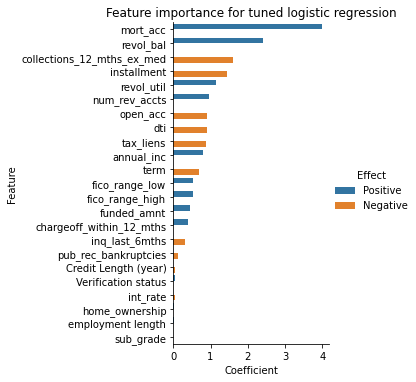

In [738]:
model_features = pd.DataFrame(lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned logistic regression'
model_features['Effect'] = 'Positive'
model_features.loc[model_features['Importance'] < 0, 'Effect'] = 'Negative'
model_features['Absolute effect'] = abs(model_features['Importance'])
data = model_features.sort_values(by='Absolute effect', ascending=False)

# Plot feature importance
sns.catplot(y= data.index, x='Absolute effect', hue='Effect', kind='bar', data=data)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')


For the logistic regression, the balanced accuracy score is 65%. 
We can see that, number of _mortage accounts_ followed by amount of _revoling balance_ are the most significant features, followed by number of _collections_ and _installment_ amount. 

Furthermore, the _sub grade_, _employment length_ and _home ownership_ has very little effect on logistic regression classification result.


In the next step, we will train a decision tree classifier.

## 7.2. Decision tree classifier <a class='anchor' id='dt'></a>
 


### 7.2.1. Make a pipeline for decision tree <a class='anchor' id='pldt'></a>

Using make_pipeline, a pipeline is created to train decision tree classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [743]:
# Make pipeline
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Save column names
Xcol_names = X.columns
ycol_name = ['Status']
# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

X_train = pd.DataFrame(X_train, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)

pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

cv_results = cross_validate(pipeTree, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74
[0.5681987  0.57353995 0.57074286 0.57097576 0.57114027]
0.5709195088337988 0.001694261725022137


 
Decision tree balanced accuracy score before hyperparameter tuning is 57%, which is worse than logistic regression. Next we will do hyperparameter tuning.

### 9.2.2. Hyperparameter search for decision tree classifier <a class='anchor' id='gddt'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [54]:
pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)
# Define grid parameters

grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_depth': [3, 6, 9, 12, 15]}

In [55]:
# Perform grid search to find hyperparameters of decision tree

tree_grid_cv = GridSearchCV(pipeTree, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
tree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               15]},
             scoring='balanced_accuracy')

### 9.2.3. Decision tree classifier with best parameters <a class='anchor' id='bestdt'></a>

We access the best parameters by using grid.best_params_

In [56]:
tree_grid_cv.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 9}

We fit a decision tree to the training data by using the best hyperparameters and then, we will look at the importance of the features.

In [95]:
#BestTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth =9, random_state = 1234)
BestTree = tree_grid_cv.best_estimator_
pipeTreeBest = make_pipeline(
    MinMaxScaler(),
    BestTree)

cv_results = cross_validate(pipeTreeBest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print('Balanced accuaracy scores of 5 fold decision tree are: ', cv_scores)
print('Mean and standard deviation of balanced accuaracy scores of 5 fold decision tree is: ', cv_scores.mean(),  ' ,' , cv_scores.std())


Balanced accuaracy scores of 5 fold decision tree are:  [0.64875248 0.64444773 0.64979896 0.64810399 0.64930863]
Mean and standard deviation of balanced accuaracy scores of 5 fold decision tree is:  0.6480823577864803  , 0.0019031851733949858


It can be seen that after hyperparameter tuning, the balanced accuracy of the decision tree model reached 65%. The hyperparameter tuning increased the score from 0.57 to 0.65. In the next step, we will plot the tree as well as the feature importance figure.

In [777]:
from sklearn.tree import export_graphviz

import os     

os.environ["PATH"] += os.pathsep + 'C://Users//somfl//anaconda3//Library//bin//graphviz'

# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(pipeTreeBest.named_steps.decisiontreeclassifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

AttributeError: decisiontreeclassifier

### 7.2.4. Feature importance assessment in the decision tree classifier <a class='anchor' id='fidt'></a>

Using the "tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_", we access the feature importance values and plot them.

Text(0, 0.5, 'Feature')

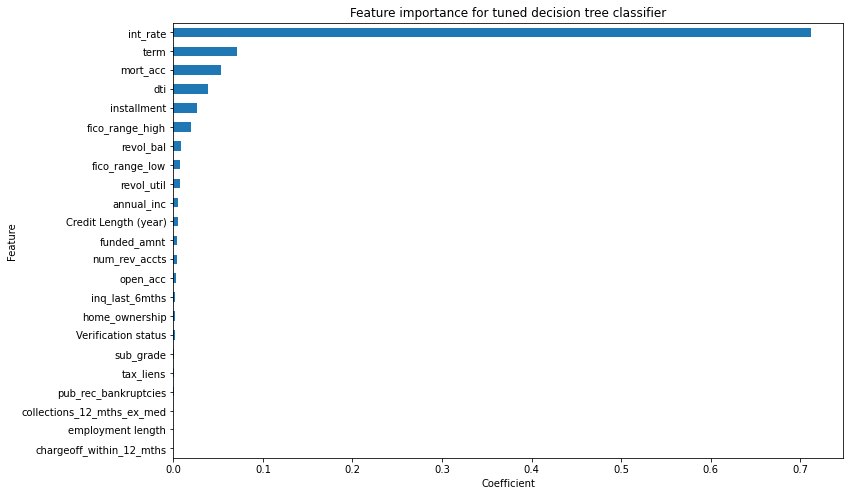

In [788]:
model_features = pd.DataFrame(tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned decision tree classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')




For the decision tree classifier, the balanced accuracy is 65% and according to the feature importance plot, _interest rate_, _loan term_ (either 30 month or 60 month), _number of mortages_, _debt to income ratio_, _installment_, _high Fico score_, _revolving balance_ and _low Fico score_ are the most influential parameters in decision tree classifier. 


Interest rate has a more significant effect than the other parameters. 


Furthermore,_sub grade_,number of _tax liens_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 7.3. Random forest classifier <a class='anchor' id='rf'></a>

### 7.3.1. Make a pipeline for random forest classifier <a class='anchor' id='plrf'></a>

Using make_pipeline, a pipeline is created to train random forest classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [789]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
cv_results = cross_validate(pipeRF, X_train, y_train, scoring='balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.65178176 0.65336846 0.65199665 0.65595819 0.65301102]
0.6532232176740888 0.0014918768343255848


### 7.3.2. Hyperparameter search for random forest classifier <a class='anchor' id='gdrf'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [43]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))

# Define a grid for hyperparameter tuning with GridSearchCV
param_grid = { 
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth' : [3, 6, 9],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}

rf_grid_cv_0  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)
rf_grid_cv_0.fit(X_train, y_train)
rf_grid_cv_0.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 150}

As seen above, best parameters for random forest are: 

1. Criterion: gini
2. max_depth: 9
3. n_estimator: 150

The search grid was:

'randomforestclassifier__n_estimators': [50, 100, 150],
'randomforestclassifier__max_depth' : [3, 6, 9],
'randomforestclassifier__criterion' :['gini', 'entropy']

It is not clear if we increase _n_estimator_ or _max_depth_, how the classifier performs. Due to lack of computational power, we will do grid search for random forest parameter in two steps. First we tune n_esimator and we search list of [150, 200, 300, 500, 700, 1000] and then we use the tune _n_estimator_ in the next grid search for max_depth and we search list of [6, 9, 15, 25, 35].



In [790]:
# First step: tuning n_estimator

param_grid = { 
    'randomforestclassifier__n_estimators': [150, 200, 300, 500, 700, 1000],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [9]
}
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
rf_grid_cv_1  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv_1.fit(X_train, y_train)
rf_best_cv_1_results = cross_validate(rf_grid_cv_1.best_estimator_, X_train, y_train, cv=5, scoring='balanced_accuracy')
rf_best_scores = rf_best_cv_1_results['test_score']
print(rf_best_scores)
print(rf_best_scores.mean(), rf_best_scores.std())

rf_grid_cv_1.best_params_

[0.65343985 0.65140765 0.65298251 0.65628705 0.65370938]
0.6535652865413835 0.0015773104130714078


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 700}

Now, we use _n_estimator_ = 700 and tune _max_depth_.

In [8]:
# Second step: tuning max_septh

param_grid = { 
    'randomforestclassifier__n_estimators': [700],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [6, 9, 15, 25, 35],
}
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
rf_grid_cv2  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv2.fit(X_train, y_train)
rf_best_cv2_results = cross_validate(rf_grid_cv2.best_estimator_, X_train, y_train, cv=5, scoring='balanced_accuracy')
rf_best_scores2 = rf_best_cv2_results['test_score']
print(rf_best_scores2)
print(rf_best_scores2.mean(), rf_best_scores2.std())

rf_grid_cv2.best_params_

[0.65487959 0.65011819 0.65239186 0.65417402 0.65440866]
0.6531944610263174 0.0017539147905660923


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 700}



It can be seen that the abalanced accuracy score for the tuned random forest is 65%, very similar to the tune decision tree and logistic regression. In the next step, we plot the feature importance to study effect of features.

### 9.3.3. Feature importance assessment of random forest classifier <a class='anchor' id='firf'></a>



Using rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_, we access the values and plot them

Text(0, 0.5, 'Feature')

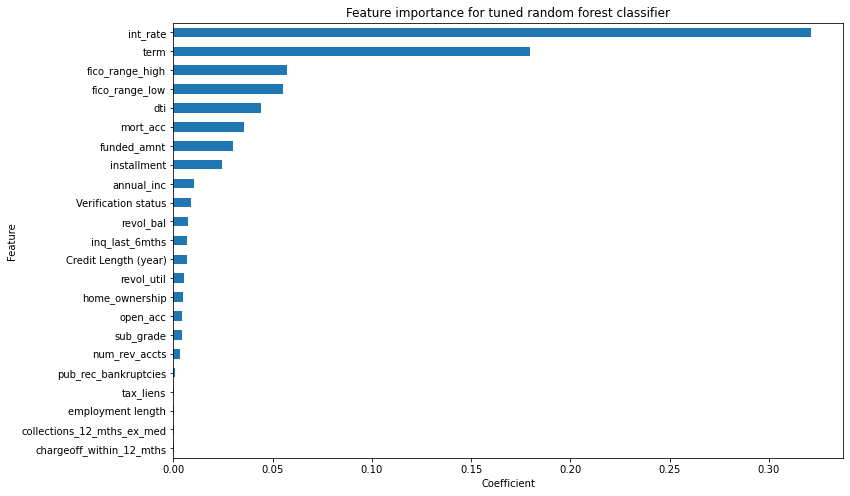

In [86]:
# Plot feature importance for random forest

model_features = pd.DataFrame(rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned random forest classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')




For tuned random forest, the balanced accuracy score is 65%, very similar to logistic regression and decision tree.

As shown in the plot,  _interest rate_, _loan term_(either it is 30 month or 60 month), _higher Fico score_ and _low Fico score_, _debt to income ratio_ , _number of mortages_, _funded amount_ and _installment_ are the most influential parameters.

It is worth mentioning that the decision tree reached to almost similar conclusion in the previous section. In a decision tree classifier, the most influential parameters were interest rate, loan term(either it is 30 month or 60 month loan), number of mortages, debt to income ratio, installment, Low Fico score, revolving balance and high Fico score.  

Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 7.4. Gradient boosting classifier <a class='anchor' id='GB'></a>

### 7.4.1. Make a pipeline for gradient boosting classifier <a class='anchor' id='plgb'></a>

Using make_pipeline, a pipeline is created to train gradient boosting classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [715]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)



pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

cv_results = cross_validate(pipeXG, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74
[12:59:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:00:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:log

Gradient boosting model balanced accuracy score is 66%, which is highest among the models. Decision tree, logistic regression and random forest reached 65% accuracy after tuning.

### 7.4.2. Hyperparameter tuning for gradient boosting classifier <a class='anchor' id='gdgb'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [108]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

Xcol_names = X.columns
ycol_name =['Status']
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)    

pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier(eval_metric='mlogloss'))

parameters = {
    'xgbclassifier__max_depth':[3, 6, 9],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
    }
grid_search_2 = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search_2.fit(X_train,y_train)

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      eval_metric='mlogloss',
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
            

In [109]:
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)

{'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 6}
0.6626399135683985


Hyperparameter tuning does not change the result significantly (.663 vs .662). 

In [106]:
pipeXGbest = make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate= 0.2, max_depth= 6, eval_metric='mlogloss'))

cv_results = cross_validate(pipeXGbest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.66283261 0.66206157 0.66765471 0.66456872 0.66414436]
0.6642523926520695 0.0019236927157257626


In [111]:
# Print best parameters and results
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)

{'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 6}
0.6626399135683985


### 9.4.3. Gradient boosting feature importance assessment <a class='anchor' id='figb'></a>

Text(0, 0.5, 'Feature')

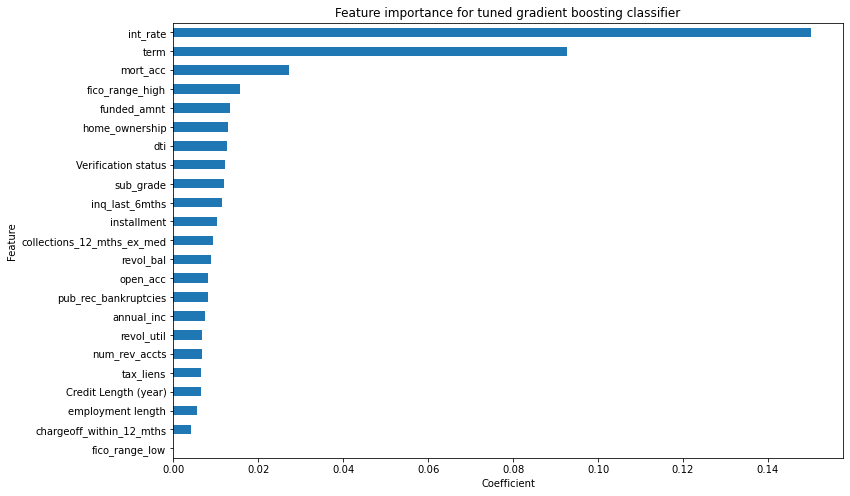

In [87]:
model_features = pd.DataFrame(pipeXGbest.named_steps['xgbclassifier'].feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned gradient boosting classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')

According to the balanced accuracy score, gradient boosting is slightly better than previous models. The balanced accuracy score is 67%.

According to the feature importance plot, _interest rate_, _term_, the number of _mortage accounts_ , followed by _high Fico score_, _funded amount_, -home ownership_, _debt to income ratio_ and income _verification status_  are the most influential parameters in the classification. _interset rate_ and _term_ have more significant effect compared to other parameters.

Among the parameters, _low Fico score_ has the lowest effect on classification.

# 8. Final model selection <a class='anchor' id='select'><a/>
    
We first define a function to plot the confussion matrix. Then we apply each model separately on the test data, read the balanced accuracy score, print the classification report and plot the confusion matrix.

In [49]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Default', 'Fully Paid']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In order to choose the best model, we looked at models' balanced accuracy score on the training set.

In [99]:
Score_result = pd.DataFrame({'Logistic regression': [0.6533, .0012], 'Decision tree': [0.6481, 0.0019], "Random forest": [.6532, .0018], "XGBoost": [.6627, .0007]})
Score_result.index = ['Mean', 'Standard deviation']
Score_result

,Logistic regression,Decision tree,Random forest,XGBoost
Mean,0.6533,0.6481,0.6532,0.6627
Standard deviation,0.0012,0.0019,0.0018,0.0007


Based on the above table, XGBoost performs slightly better and we choose it as our predictive model. In the next step, we use the selected model on our test data and plot the confussion matrix and will print the classification report.

In [71]:
xg_y_pred = pipeXGbest.predict(X_test)

print('XGBoost balanced accuracy score for the test data is: ', balanced_accuracy_score(y_test, xg_y_pred))

XGBoost balanced accuracy score for the test data is:  0.6630322341303667


In [90]:
xg_y_pred =pd.Series(xg_y_pred)
print(classification_report(y_test, xg_y_pred))

              precision    recall  f1-score   support

     Default       0.66      0.69      0.67     78117
  Fully Paid       0.67      0.64      0.65     78184

    accuracy                           0.66    156301
   macro avg       0.66      0.66      0.66    156301
weighted avg       0.66      0.66      0.66    156301



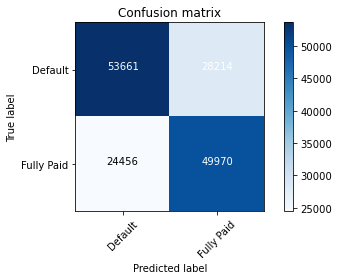

In [73]:
# Plot confusion matrix for selected model: XGBoost

confusion_matrix_xg = confusion_matrix(xg_y_pred, y_test)
plot_confusion_matrix(confusion_matrix_xg)

## 8.5. Discussion <a class='anchor' id='disc'><a/>
    
    
XGBoost performs slightly better. Its balanced accuracy is 66% versus 65% balanced accuracy of decision tree, logistic regression and random forest classifiers. Comaring f1-score, XGboost reaches 67% versus (decision tree, 64%) and (logistic regression 65%).

# 9 Save the best model <a class='anchor' id='save_model'><a/>
    
We save the model to be able to use it for later.

In [83]:

best_model = pipeXGbest.named_steps.xgbclassifier
best_model.version = '1.0'
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()


with open('XGBoost_model', 'wb') as file:
    pickle.dump(best_model,file)

# 10. Summary <a class='anchor' id='discussion'><a/>

In this notebook a predictive model was developed to predict loan default. Following steps were performed: 

1. There is 22% default in the data. Therefore, to overcome imbalanced data, undersampling was applied.

2. To reach an optimum model, the data was separated into training and test sets and four classifiers were applied to the training data.

3. For each model training cross validation with 5 folds was applied to prevent overfitting.


4. In each model training, a pipeline including scaling and modeling steps was created and by using GridSearchCV, hyperparameters were tuned. 

5. Feature importance analysis was done.

6. Trained models were used to predict the result of the testing data set. 

__Results__:


All models reached to almost same balanced accuracy score of about %65. XGBoost reached 67% accuracy.

1. For the __logistic regression__, the balanced accuracy score was 65%. The number of _mortage accounts_ and amount of _revoling balance_ followed by number of _collections_ and _installment_ amount are the most influential factors. Furthermore, the _sub grade_, _employment length_ and _home ownership_ has very little effect on logistic regression classification result.


2. For the __decision tree__,  the balanced accuracy was 65% and _interest rate_, _loan term_ (either 30 month or 60 month), _number of mortages_, _debt to income ratio_, _installment_, _high Fico score_, _revolving balance_ and _low Fico score_ are the most influential parameters in decision tree classifier. __Interest rate__ has a more significant effect than the other parameters. Furthermore,_sub grade_,number of _tax liens_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.


3. For the __random forest__, the balanced accuracy score was 66% and interest rate, loan term(either it is 30 month or 60 month), higher Fico score and low Fico score, debt to income ratio , number of mortages, funded amount and installment are the most influential parameters. Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification. It is worth mentioning that the decision tree and random forest reached to almost similar feature importance


4. For the __gradient boosting__ The balanced accuracy score was 67% and _interest rate_, _loan term_, the number of _mortage accounts_ , followed by _high Fico score_, _funded amount_, _home ownership_, _debt to income ratio_ and _income verification status_ are the most influential parameters in the classification. interset rate and term have more significant effect compared to other parameters. _Low Fico score_ has the lowest effect on classification.


5. Except for logistic regression, the three other models found _loan term_ and _interest rate_ very influential in classification. Exept for gradient boosting, the three other models found effects of _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within 12 month prior to application insignificant. 


6. To choose our predictive model, we compared results of the modelong on the training data set. 4 models results were almost similar with XGBosst slightly better. Therefore, We selected XGBoost.


7. When XGBoost, the selected model was applied to the test data, it resulted in similar similar score of the training data set. 


__Business implication__

Our model shows that a loan _interest rate_ and its _term_, number of _mortages_ an applicant has and his/her _fico score_ are determental factors in fate of a loan. The first two terms are decided on by the Lending Club based on applicant's information. The last two terms -the applicant's fico score and the number of mortages he/she has- are both indicative of the applicant's credit history. However, we should note that Lending Club asks for several pices of information about an applicant's credit history, These items are:
Credit length
Number of collections
Number of Tax liens
Number of bankruptcies
Number of revolving account
Amount of revolving balance
Number of open accounts
Credit limit and utilization rate
Fico score
Number of mortages

Our model indicates that only Fico score and number of mortages are effective factors. Furthermore, other factors such as employment length, annual income and home ownership are not important in fate of a loan. Therefore, Lending Club can save money by avoiding collecting uneffective information.



